In [38]:
import csv
import numpy as np
import Loader
import tensorflow as tf
import Transformer
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError
#use for dark mode
plt.rcParams["font.family"] = "serif"
plt.style.use('dark_background')

In [9]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

['PostEra-SAM-UNK-2684b532-12' 'GoStar-gvk_125468971'
 'enamine-PV-001916729968' 'CHEMBL3182384' 'GoStar-gvk_125485558'
 'PostEra-PET-UNK-7fb4f80a-1' 'PostEra-MAT-POS-a54ce14d-3' 'CHEMBL1370630'
 'GoStar-gvk_125468798' 'PostEra-ALP-POS-88a7a97e-38']


['GoStar-gvk_125509532ZINC68197423PostEra-ALP-POS-ecbed2ba-8GoStar-gvk_125391823GoStar-gvk_124987259ZINC3872277PostEra-MAT-POS-4223bc15-41CHEMBL309760GoStar-gvk_12539205225258088']

## Just Docking and Fusion

In [6]:
dataLabels = labelsTrain[0:20]
trainData = compoundDataTrain[:,0:20]
testData = compoundDataTest[:,0:20]
testData = compoundDataValidate[:,0:20]

['docking_score_0', 'docking_score_1', 'docking_score_2', 'docking_score_3', 'docking_score_4', 'docking_score_5', 'docking_score_6', 'docking_score_7', 'docking_score_8', 'docking_score_9', 'fusion_score_0', 'fusion_score_1', 'fusion_score_2', 'fusion_score_3', 'fusion_score_4', 'fusion_score_5', 'fusion_score_6', 'fusion_score_7', 'fusion_score_8', 'fusion_score_9']


In [35]:
def runIteration(split, epochsCount):
    
    #reload the data, (ensures data is shuffled)
    _, _, _, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
    _, _, _, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
    _, _, _, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)
    
    #transform the data, just remove any non fusion and docking 
    trainData = compoundDataTrain[:,0:20]
    testData = compoundDataTest[:,0:20]
    valData = compoundDataValidate[:,0:20]

    #normalize data
    trainData, testData, valData = Transformer.normalizeData(
        trainData, testData, valData, newMean=0, newStd=1)
    #outputs, classification here
    classVal = Transformer.toBinaryClassification(activitiesValidate)
    classTrain = Transformer.toBinaryClassification(activitiesTrain)
    
    #split data (0=1)
    trainData = trainData[0: int(split*len(trainData)) , :] #use %
    classTrain = classTrain[0: int(split*len(classTrain))] #use %
    
    print(split, len(trainData), "samples used.")
    
    l1Reg = keras.regularizers.L1(.001)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )
    inputDim = np.shape(trainData)[1] #how many inputs
    #build and run model
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(40, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(120, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(120, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(60, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(30, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2, activation='relu', kernel_regularizer = l1Reg)
        ])

    model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True), metrics=['accuracy'])

    history = model.fit(trainData, classTrain, validation_data = (valData, classVal), 
        epochs=epochsCount, batch_size=4, verbose = 1) #verbose = 0 for no printing
    
    return model, history


dataSegments = [1, .9, .75, .5, .25, .1]
modelHistories = [] #data for each of the models
averageRuns = 3
epochs = 30

for seg in dataSegments:
    segHist = []
    for i in range(averageRuns):
        tempModel, tempHistory = runIteration(seg, epochs)
        
        if(tempHistory.history["accuracy"][-1] <= .60): #terrible train performance, redo
            i = i-1 #don't use this iteration
            continue
            
        print(100*seg, '\b%', i, " iteration:")
        print("Val Accuracy: ", tempHistory.history["val_accuracy"][-1])
        print("Train Accuracy: ", tempHistory.history["accuracy"][-1])
        segHist.append(tempHistory)
    modelHistories.append(segHist) #histories for this partition of data

1 2717 samples used.
Epoch 1/30
680/680 [==============================] - 4s 3ms/step - loss: 1.2247 - accuracy: 0.4902 - val_loss: 0.6881 - val_accuracy: 0.6118
Epoch 2/30
680/680 [==============================] - 2s 3ms/step - loss: 0.6756 - accuracy: 0.6198 - val_loss: 0.6759 - val_accuracy: 0.6118
Epoch 3/30
680/680 [==============================] - 2s 2ms/step - loss: 0.6723 - accuracy: 0.6198 - val_loss: 0.6756 - val_accuracy: 0.6118
Epoch 4/30
680/680 [==============================] - 2s 3ms/step - loss: 0.6716 - accuracy: 0.6198 - val_loss: 0.6765 - val_accuracy: 0.6118
Epoch 5/30
680/680 [==============================] - 2s 2ms/step - loss: 0.6719 - accuracy: 0.6198 - val_loss: 0.6753 - val_accuracy: 0.6118
Epoch 6/30
680/680 [==============================] - 2s 3ms/step - loss: 0.6717 - accuracy: 0.6198 - val_loss: 0.6751 - val_accuracy: 0.6118
Epoch 7/30
680/680 [==============================] - 2s 2ms/step - loss: 0.6717 - accuracy: 0.6198 - val_loss: 0.6751 - val_ac

680/680 [==============================] - 3s 4ms/step - loss: 0.6993 - accuracy: 0.3802 - val_loss: 0.6992 - val_accuracy: 0.3882
Epoch 28/30
680/680 [==============================] - 2s 3ms/step - loss: 0.6993 - accuracy: 0.3802 - val_loss: 0.6993 - val_accuracy: 0.3882
Epoch 29/30
680/680 [==============================] - 2s 3ms/step - loss: 0.6993 - accuracy: 0.3802 - val_loss: 0.6993 - val_accuracy: 0.3882
Epoch 30/30
680/680 [==============================] - 2s 3ms/step - loss: 0.6993 - accuracy: 0.3802 - val_loss: 0.6993 - val_accuracy: 0.3882
1 2717 samples used.
Epoch 1/30
680/680 [==============================] - 4s 3ms/step - loss: 1.3763 - accuracy: 0.6198 - val_loss: 0.7965 - val_accuracy: 0.6118
Epoch 2/30
680/680 [==============================] - 2s 2ms/step - loss: 0.7522 - accuracy: 0.6356 - val_loss: 0.7235 - val_accuracy: 0.6500
Epoch 3/30
680/680 [==============================] - 2s 2ms/step - loss: 0.7076 - accuracy: 0.6526 - val_loss: 0.6963 - val_accuracy: 

612/612 [==============================] - 1s 2ms/step - loss: 0.6585 - accuracy: 0.6740 - val_loss: 0.6501 - val_accuracy: 0.6824
Epoch 24/30
612/612 [==============================] - 2s 3ms/step - loss: 0.6576 - accuracy: 0.6712 - val_loss: 0.6508 - val_accuracy: 0.6824
Epoch 25/30
612/612 [==============================] - 2s 3ms/step - loss: 0.6578 - accuracy: 0.6736 - val_loss: 0.6545 - val_accuracy: 0.6676
Epoch 26/30
612/612 [==============================] - 2s 2ms/step - loss: 0.6584 - accuracy: 0.6703 - val_loss: 0.6482 - val_accuracy: 0.6912
Epoch 27/30
612/612 [==============================] - 2s 3ms/step - loss: 0.6568 - accuracy: 0.6691 - val_loss: 0.6479 - val_accuracy: 0.6794
Epoch 28/30
612/612 [==============================] - 2s 3ms/step - loss: 0.6569 - accuracy: 0.6753 - val_loss: 0.6478 - val_accuracy: 0.6794
Epoch 29/30
612/612 [==============================] - 2s 3ms/step - loss: 0.6566 - accuracy: 0.6683 - val_loss: 0.6498 - val_accuracy: 0.6735
Epoch 30/30

Epoch 19/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6598 - accuracy: 0.6683 - val_loss: 0.6644 - val_accuracy: 0.6118
Epoch 20/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6594 - accuracy: 0.6720 - val_loss: 0.6580 - val_accuracy: 0.6706
Epoch 21/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6588 - accuracy: 0.6757 - val_loss: 0.6594 - val_accuracy: 0.6794
Epoch 22/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6579 - accuracy: 0.6716 - val_loss: 0.6568 - val_accuracy: 0.6676
Epoch 23/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6583 - accuracy: 0.6724 - val_loss: 0.6573 - val_accuracy: 0.6794
Epoch 24/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6580 - accuracy: 0.6744 - val_loss: 0.6568 - val_accuracy: 0.6794
Epoch 25/30
612/612 [==============================] - 2s 2ms/step - loss: 0.6580 - accuracy: 0.6732 - val_loss: 0.6571 - val_accuracy: 0.6765

510/510 [==============================] - 1s 2ms/step - loss: 0.6629 - accuracy: 0.6735 - val_loss: 0.6561 - val_accuracy: 0.6794
Epoch 16/30
510/510 [==============================] - 1s 2ms/step - loss: 0.6620 - accuracy: 0.6750 - val_loss: 0.6563 - val_accuracy: 0.6794
Epoch 17/30
510/510 [==============================] - 1s 2ms/step - loss: 0.6612 - accuracy: 0.6765 - val_loss: 0.6560 - val_accuracy: 0.6765
Epoch 18/30
510/510 [==============================] - 1s 3ms/step - loss: 0.6606 - accuracy: 0.6760 - val_loss: 0.6605 - val_accuracy: 0.6765
Epoch 19/30
510/510 [==============================] - 1s 2ms/step - loss: 0.6602 - accuracy: 0.6789 - val_loss: 0.6543 - val_accuracy: 0.6794
Epoch 20/30
510/510 [==============================] - 1s 2ms/step - loss: 0.6583 - accuracy: 0.6784 - val_loss: 0.6555 - val_accuracy: 0.6794
Epoch 21/30
510/510 [==============================] - 1s 3ms/step - loss: 0.6571 - accuracy: 0.6794 - val_loss: 0.6523 - val_accuracy: 0.6794
Epoch 22/30

Epoch 11/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6750 - accuracy: 0.6679 - val_loss: 0.6831 - val_accuracy: 0.6529
Epoch 12/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.6760 - val_loss: 0.6727 - val_accuracy: 0.6735
Epoch 13/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6694 - accuracy: 0.6760 - val_loss: 0.6719 - val_accuracy: 0.6765
Epoch 14/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6706 - accuracy: 0.6782 - val_loss: 0.6699 - val_accuracy: 0.6735
Epoch 15/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6667 - accuracy: 0.6745 - val_loss: 0.6674 - val_accuracy: 0.6765
Epoch 16/30
340/340 [==============================] - 1s 2ms/step - loss: 0.6655 - accuracy: 0.6775 - val_loss: 0.6648 - val_accuracy: 0.6735
Epoch 17/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6660 - accuracy: 0.6789 - val_loss: 0.6644 - val_accuracy: 0.6706

Epoch 7/30
340/340 [==============================] - 1s 2ms/step - loss: 0.6995 - accuracy: 0.6605 - val_loss: 0.6812 - val_accuracy: 0.6706
Epoch 8/30
340/340 [==============================] - 1s 2ms/step - loss: 0.6905 - accuracy: 0.6532 - val_loss: 0.6783 - val_accuracy: 0.6706
Epoch 9/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6884 - accuracy: 0.6635 - val_loss: 0.6745 - val_accuracy: 0.6706
Epoch 10/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6821 - accuracy: 0.6657 - val_loss: 0.6736 - val_accuracy: 0.6706
Epoch 11/30
340/340 [==============================] - 1s 2ms/step - loss: 0.6835 - accuracy: 0.6657 - val_loss: 0.6683 - val_accuracy: 0.6735
Epoch 12/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6795 - accuracy: 0.6657 - val_loss: 0.6666 - val_accuracy: 0.6706
Epoch 13/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6777 - accuracy: 0.6635 - val_loss: 0.6685 - val_accuracy: 0.6676
Ep

170/170 [==============================] - 1s 3ms/step - loss: 0.8828 - accuracy: 0.6406 - val_loss: 0.8844 - val_accuracy: 0.6118
Epoch 4/30
170/170 [==============================] - 1s 3ms/step - loss: 0.8036 - accuracy: 0.6406 - val_loss: 0.7963 - val_accuracy: 0.6118
Epoch 5/30
170/170 [==============================] - 0s 3ms/step - loss: 0.7640 - accuracy: 0.6406 - val_loss: 0.7669 - val_accuracy: 0.6118
Epoch 6/30
170/170 [==============================] - 0s 3ms/step - loss: 0.7418 - accuracy: 0.6406 - val_loss: 0.7521 - val_accuracy: 0.6118
Epoch 7/30
170/170 [==============================] - 1s 3ms/step - loss: 0.7225 - accuracy: 0.6406 - val_loss: 0.7342 - val_accuracy: 0.6118
Epoch 8/30
170/170 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.6406 - val_loss: 0.7292 - val_accuracy: 0.6118
Epoch 9/30
170/170 [==============================] - 1s 3ms/step - loss: 0.7019 - accuracy: 0.6406 - val_loss: 0.7163 - val_accuracy: 0.6118
Epoch 10/30
170/1

Epoch 30/30
170/170 [==============================] - 1s 3ms/step - loss: 0.6584 - accuracy: 0.6892 - val_loss: 0.6658 - val_accuracy: 0.6765
25.0%% 2  iteration:
Val Accuracy:  0.6764705777168274
Train Accuracy:  0.6892489194869995
0.1 271 samples used.
Epoch 1/30
68/68 [==============================] - 3s 11ms/step - loss: 3.7910 - accuracy: 0.6052 - val_loss: 2.6697 - val_accuracy: 0.6118
Epoch 2/30
68/68 [==============================] - 0s 4ms/step - loss: 1.9515 - accuracy: 0.6015 - val_loss: 1.3737 - val_accuracy: 0.6118
Epoch 3/30
68/68 [==============================] - 0s 4ms/step - loss: 1.1336 - accuracy: 0.6015 - val_loss: 0.9798 - val_accuracy: 0.6118
Epoch 4/30
68/68 [==============================] - 0s 4ms/step - loss: 0.9267 - accuracy: 0.6015 - val_loss: 0.8763 - val_accuracy: 0.6118
Epoch 5/30
68/68 [==============================] - 0s 4ms/step - loss: 0.8553 - accuracy: 0.6015 - val_loss: 0.8348 - val_accuracy: 0.6118
Epoch 6/30
68/68 [=========================

68/68 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.7085 - val_loss: 0.7311 - val_accuracy: 0.6118
Epoch 27/30
68/68 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.6863 - val_loss: 0.7306 - val_accuracy: 0.6118
Epoch 28/30
68/68 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.7048 - val_loss: 0.7331 - val_accuracy: 0.6118
Epoch 29/30
68/68 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.6753 - val_loss: 0.7257 - val_accuracy: 0.6647
Epoch 30/30
68/68 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.7085 - val_loss: 0.7286 - val_accuracy: 0.6706
10.0%% 1  iteration:
Val Accuracy:  0.6705882549285889
Train Accuracy:  0.7084870934486389
0.1 271 samples used.
Epoch 1/30
68/68 [==============================] - 2s 10ms/step - loss: 3.9528 - accuracy: 0.6236 - val_loss: 3.0364 - val_accuracy: 0.6529
Epoch 2/30
68/68 [==============================] - 0

Partition: 100 %, Train Acc:  0.6496135294437408 Val Acc:  0.6455882489681244
Partition: 90.0 %, Train Acc:  0.6725289622942606 Val Acc:  0.6823529402414957
Partition: 75.0 %, Train Acc:  0.6836033463478088 Val Acc:  0.6808823347091675
Partition: 50.0 %, Train Acc:  0.6823760469754537 Val Acc:  0.6686274409294128
Partition: 25.0 %, Train Acc:  0.673785001039505 Val Acc:  0.6720588207244873
Partition: 10.0 %, Train Acc:  0.6826568245887756 Val Acc:  0.6529411872227987


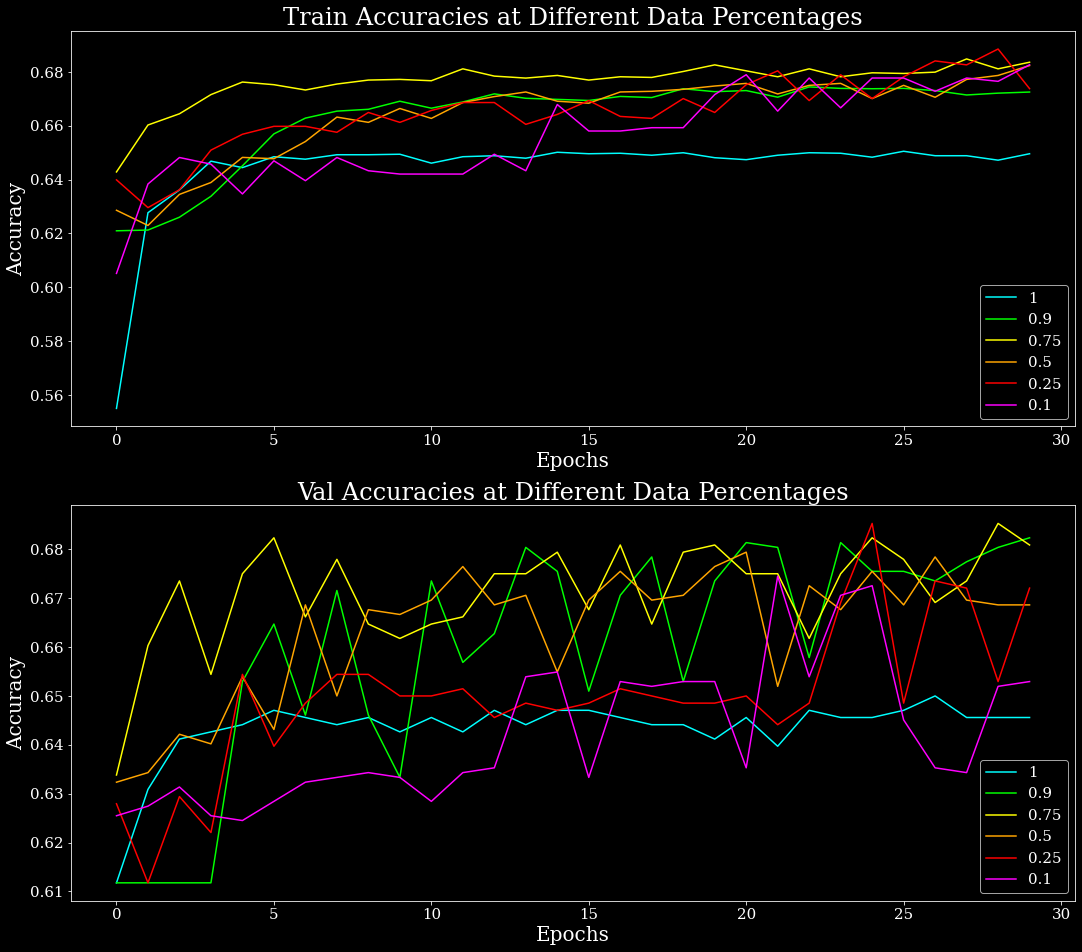

In [51]:
fig, ax = plt.subplots(2, figsize=(18,16))
colors = ["cyan", "lime", "yellow", "orange", "red", "magenta"]

for i in range(len(dataSegments)):
    allAcc = []
    allAccVal = []
    for j in range(len(modelHistories[i])): #get accuracies formatted nicely
        allAcc.append(modelHistories[i][j].history["accuracy"])
        allAccVal.append(modelHistories[i][j].history["val_accuracy"])
    
    avrAcc = np.average(allAcc, axis=0) #average all the accuracies
    avrAccVal = np.average(allAccVal, axis=0) #average all the accuracies
    
    print("Partition:", 100*dataSegments[i], "\b%, Train Acc: ", avrAcc[-1], "Val Acc: ", avrAccVal[-1])
    
    ax[0].plot(avrAcc, label=dataSegments[i], color=colors[i])
    ax[1].plot(avrAccVal, label=dataSegments[i], color=colors[i])
    
    
ax[0].set_title("Train Accuracies at Different Data Percentages", fontsize = 24)
ax[1].set_title("Val Accuracies at Different Data Percentages", fontsize = 24)

for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(loc = 'lower right', fontsize = 15)
    ax[i].set_xlabel("Epochs", fontsize = 20)
    ax[i].set_ylabel("Accuracy", fontsize = 20)

## Just docking and fusion but regression
It's gonna be so bad

In [54]:
def runIteration(split, epochsCount):
    
    #reload the data, (ensures data is shuffled)
    _, _, _, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
    _, _, _, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
    _, _, _, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)
    
    #transform the data, just remove any non fusion and docking 
    trainData = compoundDataTrain[:,0:20]
    testData = compoundDataTest[:,0:20]
    valData = compoundDataValidate[:,0:20]

    #normalize data
    trainData, testData, valData = Transformer.normalizeData(
        trainData, testData, valData, newMean=0, newStd=1)
    
    #split data (0=1)
    trainData = trainData[0: int(split*len(trainData)) , :] #use %
    activitiesTrain = activitiesTrain[0: int(split*len(activitiesTrain))] #use %
    
    print(split, len(trainData), "samples used.")
    
    l1Reg = keras.regularizers.L1(.001)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )
    inputDim = np.shape(trainData)[1] #how many inputs
    #build and run model
    
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(40, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(120, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(120, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(60, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(30, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = l1Reg)
        ])

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['MeanSquaredError'])

    history = model.fit(trainData, activitiesTrain, validation_data = (valData, activitiesValidate), 
        epochs=epochsCount, batch_size=4, verbose = 1) #verbose = 0 for no printing
    
    return model, history


dataSegments = [1, .9, .75, .5, .25, .1]
modelHistories = [] #data for each of the models
averageRuns = 3
epochs = 30

for seg in dataSegments:
    segHist = []
    for i in range(averageRuns):
        tempModel, tempHistory = runIteration(seg, epochs)
        
        if(tempHistory.history["mean_squared_error"][-1] >= 12): #terrible train performance, redo
            i = i-1 #don't use this iteration
            continue
            
        print(100*seg, '\b%', i, " iteration:")
        print("Val Error: ", tempHistory.history["val_mean_squared_error"][-1])
        print("Train Error: ", tempHistory.history["mean_squared_error"][-1])
        segHist.append(tempHistory)
    modelHistories.append(segHist) #histories for this partition of data

1 2717 samples used.
Epoch 1/30
680/680 [==============================] - 5s 3ms/step - loss: 11.5710 - mean_squared_error: 9.2539 - val_loss: 9.9956 - val_mean_squared_error: 8.1856
Epoch 2/30
680/680 [==============================] - 2s 3ms/step - loss: 9.8484 - mean_squared_error: 8.2570 - val_loss: 9.5716 - val_mean_squared_error: 8.1663
Epoch 3/30
680/680 [==============================] - 2s 3ms/step - loss: 9.4621 - mean_squared_error: 8.1990 - val_loss: 9.2400 - val_mean_squared_error: 8.1060
Epoch 4/30
680/680 [==============================] - 2s 3ms/step - loss: 9.2350 - mean_squared_error: 8.2011 - val_loss: 9.1714 - val_mean_squared_error: 8.2309
Epoch 5/30
680/680 [==============================] - 2s 3ms/step - loss: 8.9804 - mean_squared_error: 8.1118 - val_loss: 9.0273 - val_mean_squared_error: 8.2250
Epoch 6/30
680/680 [==============================] - 2s 3ms/step - loss: 8.8407 - mean_squared_error: 8.0961 - val_loss: 8.7055 - val_mean_squared_error: 8.0184
Epoch 

680/680 [==============================] - 2s 3ms/step - loss: 22.7632 - mean_squared_error: 22.7571 - val_loss: 22.8084 - val_mean_squared_error: 22.8023
Epoch 21/30
680/680 [==============================] - 2s 3ms/step - loss: 22.7632 - mean_squared_error: 22.7571 - val_loss: 22.8085 - val_mean_squared_error: 22.8023
Epoch 22/30
680/680 [==============================] - 2s 3ms/step - loss: 22.7632 - mean_squared_error: 22.7571 - val_loss: 22.8084 - val_mean_squared_error: 22.8023
Epoch 23/30
680/680 [==============================] - 2s 3ms/step - loss: 22.7632 - mean_squared_error: 22.7571 - val_loss: 22.8084 - val_mean_squared_error: 22.8023
Epoch 24/30
680/680 [==============================] - 2s 3ms/step - loss: 22.7633 - mean_squared_error: 22.7571 - val_loss: 22.8084 - val_mean_squared_error: 22.8023
Epoch 25/30
680/680 [==============================] - 2s 3ms/step - loss: 22.7632 - mean_squared_error: 22.7571 - val_loss: 22.8085 - val_mean_squared_error: 22.8023
Epoch 26/3

612/612 [==============================] - 2s 3ms/step - loss: 8.4691 - mean_squared_error: 7.8423 - val_loss: 8.7426 - val_mean_squared_error: 8.1413
Epoch 10/30
612/612 [==============================] - 2s 3ms/step - loss: 8.3354 - mean_squared_error: 7.7521 - val_loss: 8.7609 - val_mean_squared_error: 8.1935
Epoch 11/30
612/612 [==============================] - 2s 3ms/step - loss: 8.2402 - mean_squared_error: 7.6920 - val_loss: 8.9940 - val_mean_squared_error: 8.4650
Epoch 12/30
612/612 [==============================] - 2s 3ms/step - loss: 8.1214 - mean_squared_error: 7.6027 - val_loss: 8.7400 - val_mean_squared_error: 8.2357
Epoch 13/30
612/612 [==============================] - 2s 3ms/step - loss: 8.0886 - mean_squared_error: 7.5920 - val_loss: 8.6853 - val_mean_squared_error: 8.1978
Epoch 14/30
612/612 [==============================] - 2s 3ms/step - loss: 7.9393 - mean_squared_error: 7.4607 - val_loss: 8.5754 - val_mean_squared_error: 8.1086
Epoch 15/30
612/612 [=============

Epoch 29/30
612/612 [==============================] - 2s 3ms/step - loss: 7.2644 - mean_squared_error: 6.8375 - val_loss: 9.0596 - val_mean_squared_error: 8.6314
Epoch 30/30
612/612 [==============================] - 2s 3ms/step - loss: 7.2530 - mean_squared_error: 6.8247 - val_loss: 9.1030 - val_mean_squared_error: 8.6770
90.0% 1  iteration:
Val Error:  8.67700481414795
Train Error:  6.824666976928711
0.9 2445 samples used.
Epoch 1/30
612/612 [==============================] - 4s 3ms/step - loss: 14.6416 - mean_squared_error: 14.0863 - val_loss: 9.3243 - val_mean_squared_error: 9.1708
Epoch 2/30
612/612 [==============================] - 2s 3ms/step - loss: 9.1987 - mean_squared_error: 9.0521 - val_loss: 9.4194 - val_mean_squared_error: 9.2727
Epoch 3/30
612/612 [==============================] - 2s 3ms/step - loss: 9.2142 - mean_squared_error: 9.0769 - val_loss: 9.3718 - val_mean_squared_error: 9.2346
Epoch 4/30
612/612 [==============================] - 2s 3ms/step - loss: 9.1938 -

510/510 [==============================] - 1s 3ms/step - loss: 7.7194 - mean_squared_error: 7.2590 - val_loss: 8.7127 - val_mean_squared_error: 8.2542
Epoch 19/30
510/510 [==============================] - 1s 3ms/step - loss: 7.7474 - mean_squared_error: 7.2958 - val_loss: 8.7201 - val_mean_squared_error: 8.2729
Epoch 20/30
510/510 [==============================] - 1s 3ms/step - loss: 7.7075 - mean_squared_error: 7.2636 - val_loss: 8.8315 - val_mean_squared_error: 8.3869
Epoch 21/30
510/510 [==============================] - 1s 3ms/step - loss: 7.5761 - mean_squared_error: 7.1362 - val_loss: 8.7224 - val_mean_squared_error: 8.2854
Epoch 22/30
510/510 [==============================] - 1s 3ms/step - loss: 7.5560 - mean_squared_error: 7.1215 - val_loss: 8.6883 - val_mean_squared_error: 8.2573
Epoch 23/30
510/510 [==============================] - 1s 3ms/step - loss: 7.4520 - mean_squared_error: 7.0213 - val_loss: 8.4985 - val_mean_squared_error: 8.0684
Epoch 24/30
510/510 [=============

510/510 [==============================] - 1s 3ms/step - loss: 8.7230 - mean_squared_error: 7.9758 - val_loss: 8.9428 - val_mean_squared_error: 8.2351
Epoch 8/30
510/510 [==============================] - 1s 3ms/step - loss: 8.6913 - mean_squared_error: 8.0082 - val_loss: 9.0037 - val_mean_squared_error: 8.3455
Epoch 9/30
510/510 [==============================] - 1s 3ms/step - loss: 8.4306 - mean_squared_error: 7.7985 - val_loss: 8.4786 - val_mean_squared_error: 7.8668
Epoch 10/30
510/510 [==============================] - 1s 3ms/step - loss: 8.4460 - mean_squared_error: 7.8492 - val_loss: 8.5905 - val_mean_squared_error: 8.0071
Epoch 11/30
510/510 [==============================] - 1s 3ms/step - loss: 8.2873 - mean_squared_error: 7.7223 - val_loss: 8.5458 - val_mean_squared_error: 7.9970
Epoch 12/30
510/510 [==============================] - 1s 3ms/step - loss: 8.1981 - mean_squared_error: 7.6606 - val_loss: 8.5140 - val_mean_squared_error: 7.9881
Epoch 13/30
510/510 [===============

340/340 [==============================] - 1s 3ms/step - loss: 23.3826 - mean_squared_error: 23.3765 - val_loss: 22.8084 - val_mean_squared_error: 22.8023
Epoch 27/30
340/340 [==============================] - 1s 3ms/step - loss: 23.3826 - mean_squared_error: 23.3765 - val_loss: 22.8085 - val_mean_squared_error: 22.8023
Epoch 28/30
340/340 [==============================] - 1s 3ms/step - loss: 23.3826 - mean_squared_error: 23.3765 - val_loss: 22.8084 - val_mean_squared_error: 22.8023
Epoch 29/30
340/340 [==============================] - 1s 3ms/step - loss: 23.3826 - mean_squared_error: 23.3765 - val_loss: 22.8084 - val_mean_squared_error: 22.8023
Epoch 30/30
340/340 [==============================] - 1s 3ms/step - loss: 23.3826 - mean_squared_error: 23.3765 - val_loss: 22.8085 - val_mean_squared_error: 22.8023
0.5 1358 samples used.
Epoch 1/30
340/340 [==============================] - 3s 4ms/step - loss: 12.4441 - mean_squared_error: 9.8102 - val_loss: 10.5449 - val_mean_squared_erro

340/340 [==============================] - 1s 3ms/step - loss: 8.0805 - mean_squared_error: 7.4231 - val_loss: 8.9453 - val_mean_squared_error: 8.2966
Epoch 16/30
340/340 [==============================] - 1s 3ms/step - loss: 7.9636 - mean_squared_error: 7.3261 - val_loss: 8.8631 - val_mean_squared_error: 8.2326
Epoch 17/30
340/340 [==============================] - 1s 3ms/step - loss: 7.8902 - mean_squared_error: 7.2699 - val_loss: 9.6713 - val_mean_squared_error: 9.0618
Epoch 18/30
340/340 [==============================] - 1s 3ms/step - loss: 7.8712 - mean_squared_error: 7.2661 - val_loss: 9.9174 - val_mean_squared_error: 9.3177
Epoch 19/30
340/340 [==============================] - 1s 3ms/step - loss: 7.8045 - mean_squared_error: 7.2100 - val_loss: 10.0042 - val_mean_squared_error: 9.4152
Epoch 20/30
340/340 [==============================] - 1s 3ms/step - loss: 7.6201 - mean_squared_error: 7.0387 - val_loss: 9.2228 - val_mean_squared_error: 8.6501
Epoch 21/30
340/340 [============

Epoch 4/30
170/170 [==============================] - 1s 3ms/step - loss: 9.7685 - mean_squared_error: 8.1385 - val_loss: 9.8758 - val_mean_squared_error: 8.2999
Epoch 5/30
170/170 [==============================] - 1s 3ms/step - loss: 9.5448 - mean_squared_error: 8.0130 - val_loss: 9.9955 - val_mean_squared_error: 8.5053
Epoch 6/30
170/170 [==============================] - 1s 3ms/step - loss: 9.4090 - mean_squared_error: 7.9551 - val_loss: 9.7550 - val_mean_squared_error: 8.3365
Epoch 7/30
170/170 [==============================] - 1s 3ms/step - loss: 9.2163 - mean_squared_error: 7.8279 - val_loss: 10.0258 - val_mean_squared_error: 8.6620
Epoch 8/30
170/170 [==============================] - 1s 3ms/step - loss: 9.0614 - mean_squared_error: 7.7294 - val_loss: 9.6282 - val_mean_squared_error: 8.3253
Epoch 9/30
170/170 [==============================] - 1s 3ms/step - loss: 9.2351 - mean_squared_error: 7.9558 - val_loss: 9.4843 - val_mean_squared_error: 8.2283
Epoch 10/30
170/170 [======

Epoch 24/30
170/170 [==============================] - 1s 3ms/step - loss: 7.1249 - mean_squared_error: 6.2808 - val_loss: 9.0835 - val_mean_squared_error: 8.2491
Epoch 25/30
170/170 [==============================] - 1s 3ms/step - loss: 6.9585 - mean_squared_error: 6.1265 - val_loss: 9.2872 - val_mean_squared_error: 8.4566
Epoch 26/30
170/170 [==============================] - 1s 3ms/step - loss: 6.6864 - mean_squared_error: 5.8561 - val_loss: 9.2832 - val_mean_squared_error: 8.4590
Epoch 27/30
170/170 [==============================] - 1s 3ms/step - loss: 6.6509 - mean_squared_error: 5.8302 - val_loss: 9.9540 - val_mean_squared_error: 9.1393
Epoch 28/30
170/170 [==============================] - 1s 3ms/step - loss: 6.5101 - mean_squared_error: 5.6944 - val_loss: 9.4750 - val_mean_squared_error: 8.6674
Epoch 29/30
170/170 [==============================] - 1s 3ms/step - loss: 6.8340 - mean_squared_error: 6.0289 - val_loss: 9.2695 - val_mean_squared_error: 8.4731
Epoch 30/30
170/170 [=

68/68 [==============================] - 0s 4ms/step - loss: 7.6515 - mean_squared_error: 6.1433 - val_loss: 10.8896 - val_mean_squared_error: 9.3979
Epoch 14/30
68/68 [==============================] - 0s 4ms/step - loss: 7.3775 - mean_squared_error: 5.9021 - val_loss: 10.2184 - val_mean_squared_error: 8.7627
Epoch 15/30
68/68 [==============================] - 0s 4ms/step - loss: 7.4847 - mean_squared_error: 6.0422 - val_loss: 10.0010 - val_mean_squared_error: 8.5749
Epoch 16/30
68/68 [==============================] - 0s 4ms/step - loss: 7.1571 - mean_squared_error: 5.7419 - val_loss: 11.3545 - val_mean_squared_error: 9.9517
Epoch 17/30
68/68 [==============================] - 0s 4ms/step - loss: 6.6698 - mean_squared_error: 5.2812 - val_loss: 10.7748 - val_mean_squared_error: 9.3983
Epoch 18/30
68/68 [==============================] - 0s 4ms/step - loss: 6.6465 - mean_squared_error: 5.2809 - val_loss: 11.3832 - val_mean_squared_error: 10.0262
Epoch 19/30
68/68 [====================

Partition: 100 %, Train Err:  6.84648060798645 Val Err:  9.1825590133667
Partition: 90.0 %, Train Err:  7.537901560465495 Val Err:  8.791896184285482
Partition: 75.0 %, Train Err:  6.721843878428142 Val Err:  8.094539642333984
Partition: 50.0 %, Train Err:  6.004640102386475 Val Err:  9.081593990325928
Partition: 25.0 %, Train Err:  5.7922210693359375 Val Err:  9.235706011454264
Partition: 10.0 %, Train Err:  3.9683539072672525 Val Err:  10.909477869669596


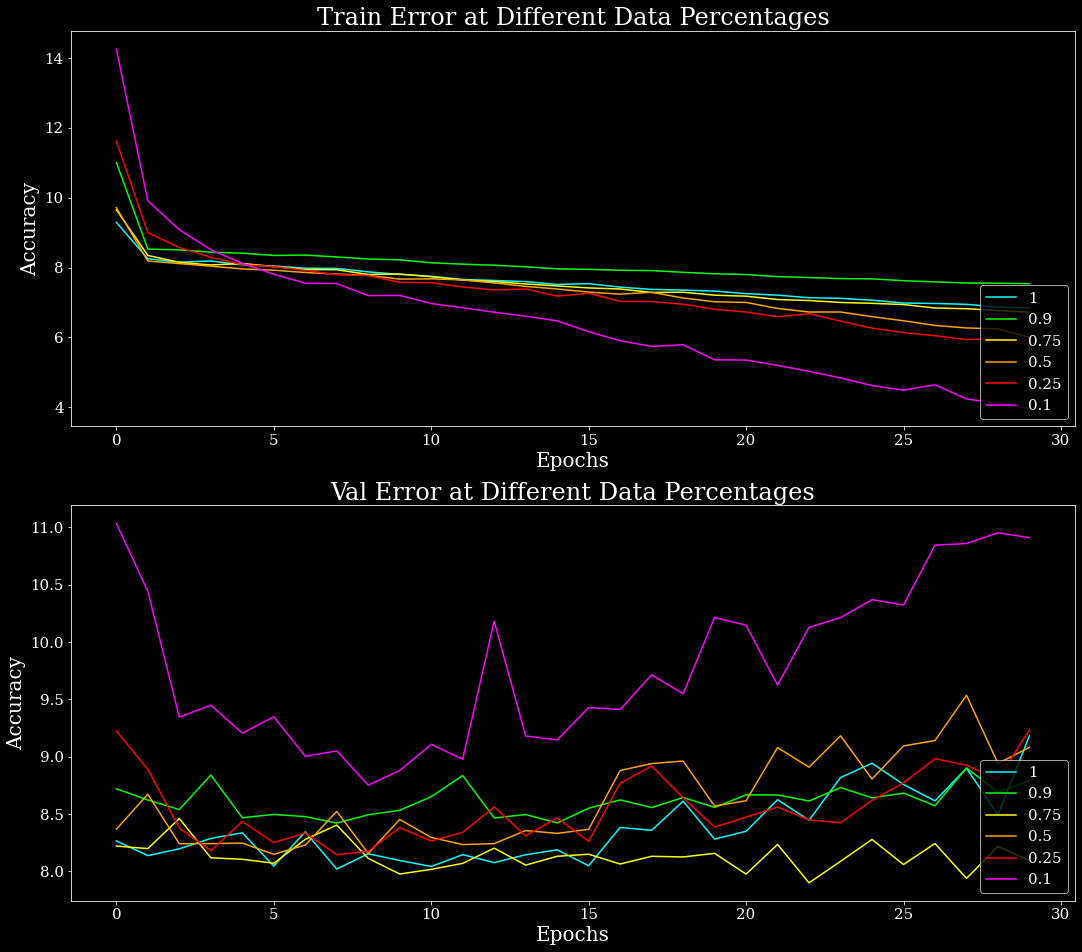

In [58]:
fig, ax = plt.subplots(2, figsize=(18,16))
colors = ["cyan", "lime", "yellow", "orange", "red", "magenta"]

for i in range(len(dataSegments)):
    allErr = []
    allErrVal = []
    for j in range(len(modelHistories[i])): #get accuracies formatted nicely
        allErr.append(modelHistories[i][j].history["mean_squared_error"])
        allErrVal.append(modelHistories[i][j].history["val_mean_squared_error"])
    
    avrErr = np.average(allErr, axis=0) #average all the accuracies
    avrErrVal = np.average(allErrVal, axis=0) #average all the accuracies
    
    print("Partition:", 100*dataSegments[i], "\b%, Train Err: ", avrErr[-1], "Val Err: ", avrErrVal[-1])
    
    ax[0].plot(avrErr, label=dataSegments[i], color=colors[i])
    ax[1].plot(avrErrVal, label=dataSegments[i], color=colors[i])
    
    
ax[0].set_title("Train Error at Different Data Percentages", fontsize = 24)
ax[1].set_title("Val Error at Different Data Percentages", fontsize = 24)

for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(loc = 'lower right', fontsize = 15)
    ax[i].set_xlabel("Epochs", fontsize = 20)
    ax[i].set_ylabel("Accuracy", fontsize = 20)